In [ ]:
from google.colab import drive

# Mounting Google Drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Listing the files inside the Google Drive directory (Use your own directory)
!ls "/content/gdrive/MyDrive/CS464"

'Colab Notebooks'   dataset  'HW1 DATASET'


In [ ]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
import pandas as pd
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.colors import ListedColormap
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn import tree


In [ ]:
dataset_path = "/content/gdrive/MyDrive/CS464/dataset"

#Preprocessing

First pull the dataset(FER2013) into separate numpy arrays.                          
At the end of this chunk we are going to have 6 numpy arrays which are X_train, y_train, X_val, y_val, X_test, y_test.

Train sets will be used in model training. With validation data, we are going to test the model and try to tune it.                                    

 Lastly, we are going to calculate final predictions and confusion matrix with test sets.

In [ ]:
def getFaceImages(emotions, data_type, print_n=False):
    images = []
    labels = []
    path = "/content/gdrive/MyDrive/CS464/dataset/" + data_type + "/"
    for i,f in enumerate(emotions):
        p = path + f
        j=0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (48, 48))
            images.append(image)
            labels.append(i)
            j+=1
        if(print_n):
            print("There are " , j , " " , data_type.upper(), " images of " , emotions[i].upper())
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

emotions = ['angry','disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#Get Images and Labels
X, y =  getFaceImages(emotions, 'train', print_n=True)

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = getFaceImages(emotions, 'test', print_n=True)

There are  3995   TRAIN  images of  ANGRY
There are  436   TRAIN  images of  DISGUST
There are  4097   TRAIN  images of  FEAR
There are  7221   TRAIN  images of  HAPPY
There are  4965   TRAIN  images of  NEUTRAL
There are  4830   TRAIN  images of  SAD
There are  3171   TRAIN  images of  SURPRISE
There are  958   TEST  images of  ANGRY
There are  111   TEST  images of  DISGUST
There are  1024   TEST  images of  FEAR
There are  1774   TEST  images of  HAPPY
There are  1239   TEST  images of  NEUTRAL
There are  1247   TEST  images of  SAD
There are  831   TEST  images of  SURPRISE



Decision trees are generally not sensitive to the scale of input features. Therefore, for decision tree-based models scaling is not necessary. Decision trees make decisions based on the relationships between features, and the scale of individual features does not impact their performance.

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform([i.flatten() for i in X_train])
# X_val = scaler.fit_transform([i.flatten() for i in X_val])
# X_test = scaler.fit_transform([i.flatten() for i in X_test])

Instead we need to do do only flattenining

In [ ]:
X_train_flatten = np.array([i.flatten() for i in X_train])
X_val_flatten = np.array([i.flatten() for i in X_val])
X_test_flatten = np.array([i.flatten() for i in X_test])

However, the set is not ready yet, it needs more processing due to skewed dataset. At that point, we look for different preprocessing solutions and found that the most sensible one is class weighting because, we already have a huge process time and we do not want to increase it further.

#Tuning (Validation)

Grid Search

In [ ]:
# param_grid_all = {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'max_leaf_nodes': [None, 5, 10, 20],
#     'min_impurity_decrease': [0.0, 0.1, 0.2],
#     'class_weight': [None, 'balanced'],
# }

For computational time to decrease, only essential ones should be chosen. Because of this, prior information on what to search and what to not gains improtance.

For visual data, choosing between 'gini' and 'entropy' depends on whether different features have varied importance. If your dataset is imbalanced, adjusting class weights, especially with 'balanced,' helps the model pay attention to all classes, ensuring it doesn't favor the majority. These choices are key for a better decision tree model in visual datasets. It is also meaningless to add max_features because x_train_flatten only include 1 feature. Therefore, it is sensible to exclude  them from search grid.

In [ ]:
param_grid1 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4,8,12,16,20]
}

grid_model1 = DecisionTreeClassifier(random_state=42)
# Create the grid search object
grid_search1 = GridSearchCV(estimator=grid_model1, param_grid=param_grid1, scoring='accuracy', cv=5)
# Fit the grid search to the data
grid_search1.fit(X_train_flatten, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 16, 20]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters from the grid search
best_params1 = grid_search1.best_params_
print("Best Hyperparameters:", best_params1)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 8}


In [ ]:
# Use the best model to make predictions on the validation set
best_grid_model = grid_search1.best_estimator_
y_pred_val1 = best_grid_model.predict(X_val_flatten)
y_pred_val1

array([2, 4, 4, ..., 3, 3, 6])

In [ ]:
cm1 = confusion_matrix(y_pred_val1,y_val)
print(cm1)
accuracy_score(y_val, y_pred_val1)

[[ 73   5  59  60  33  50  38]
 [  0   1   0   0   0   0   1]
 [ 46  10  81  67  47  66  53]
 [318  36 304 903 381 370 139]
 [152  27 171 254 321 227 109]
 [130  10 127 144 116 200  44]
 [ 59   3  93  56  49  72 238]]


0.3163851645481456

Make a dataframe

In [ ]:
param_sets1 = grid_search1.cv_results_['params']
criterion_values1 = [params['criterion'] for params in param_sets1]
max_depth_values1 = [params['max_depth'] for params in param_sets1]
accuracy_results1 = grid_search1.cv_results_['mean_test_score']
# Create a DataFrame to display the results
results_df1 = pd.DataFrame({ 'Accuracy': accuracy_results1, 'Criterion': criterion_values1, 'Max_Depth': max_depth_values1})


In [ ]:
transpose_df1 = results_df1.transpose()
transpose_df1

,0,1,2,3,4,5,6,7,8,9
Accuracy,0.291398,0.293052,0.291659,0.291485,0.295055,0.288177,0.301105,0.288917,0.289265,0.288525
Criterion,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy
Max Depth,4,8,12,16,20,4,8,12,16,20


Draw a graph

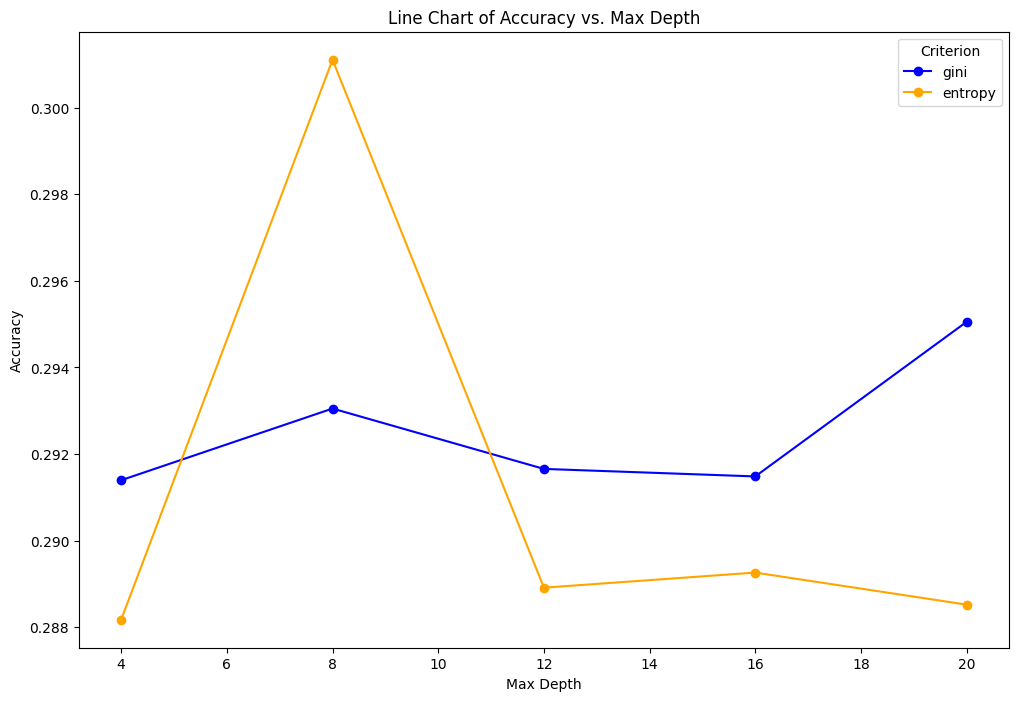

In [ ]:
gini_data1 = results_df1[results_df1['Criterion'] == 'gini']
entropy_data1 = results_df1[results_df1['Criterion'] == 'entropy']

# Create a line chart for max depth vs. accuracy, colored by criterion
plt.figure(figsize=(12, 8))

plt.plot(gini_data1['Max Depth'], gini_data1['Accuracy'], label='gini', marker='o', linestyle='-', color='blue')
plt.plot(entropy_data1['Max Depth'], entropy_data1['Accuracy'], label='entropy', marker='o', linestyle='-', color='orange')

plt.title('Line Chart of Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend(title='Criterion')
plt.show()

In [ ]:
param_grid2 = {
    'criterion': ["entropy"],
    'max_depth': [6,8,10],
    'min_impurity_decrease': [0, 1, 2]
}

grid_model2 = DecisionTreeClassifier(random_state=42)
# Create the grid search object
grid_search2 = GridSearchCV(estimator=grid_model2, param_grid=param_grid2, scoring='accuracy', cv=5)
# Fit the grid search to the data
grid_search2.fit(X_train_flatten, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy'], 'max_depth': [6, 8, 10],
                         'min_impurity_decrease': [0, 1, 2]},
             scoring='accuracy')

In [ ]:
# Get the best hyperparameters from the grid search
best_params2 = grid_search2.best_params_
print("Best Hyperparameters:", best_params2)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0}


In [ ]:
# Use the best model to make predictions on the validation set
best_grid_model2 = grid_search2.best_estimator_
y_pred_val2 = best_grid_model2.predict(X_val_flatten)
y_pred_val2

array([2, 4, 4, ..., 3, 3, 6])

In [ ]:
cm2 = confusion_matrix(y_pred_val2,y_val)
print(cm2)
accuracy_score(y_val, y_pred_val2)

[[ 73   5  59  60  33  50  38]
 [  0   1   0   0   0   0   1]
 [ 46  10  81  67  47  66  53]
 [318  36 304 903 381 370 139]
 [152  27 171 254 321 227 109]
 [130  10 127 144 116 200  44]
 [ 59   3  93  56  49  72 238]]


0.3163851645481456

Make second dataframe

In [ ]:
param_sets2 = grid_search2.cv_results_['params']
min_impurity2 = [params['min_impurity_decrease'] for params in param_sets2]
max_depth_values2 = [params['max_depth'] for params in param_sets2]
accuracy_results2 = grid_search2.cv_results_['mean_test_score']
# Create a DataFrame to display the results
results_df2 = pd.DataFrame({ 'Accuracy': accuracy_results2, 'Min Impurity': min_impurity2, 'Max Depth': max_depth_values2})
results_df2

,Accuracy,Min Impurity,Max Depth
0,0.295751,0,6
1,0.249739,1,6
2,0.249739,2,6
3,0.301105,0,8
4,0.249739,1,8
5,0.249739,2,8
6,0.294706,0,10
7,0.249739,1,10
8,0.249739,2,10


In [ ]:
transpose_df2 = results_df2.transpose()
transpose_df2

,0,1,2,3,4,5,6,7,8
Accuracy,0.295751,0.249739,0.249739,0.301105,0.249739,0.249739,0.294706,0.249739,0.249739
Min Impurity,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000
Max Depth,6.000000,6.000000,6.000000,8.000000,8.000000,8.000000,10.000000,10.000000,10.000000


Draw second graph

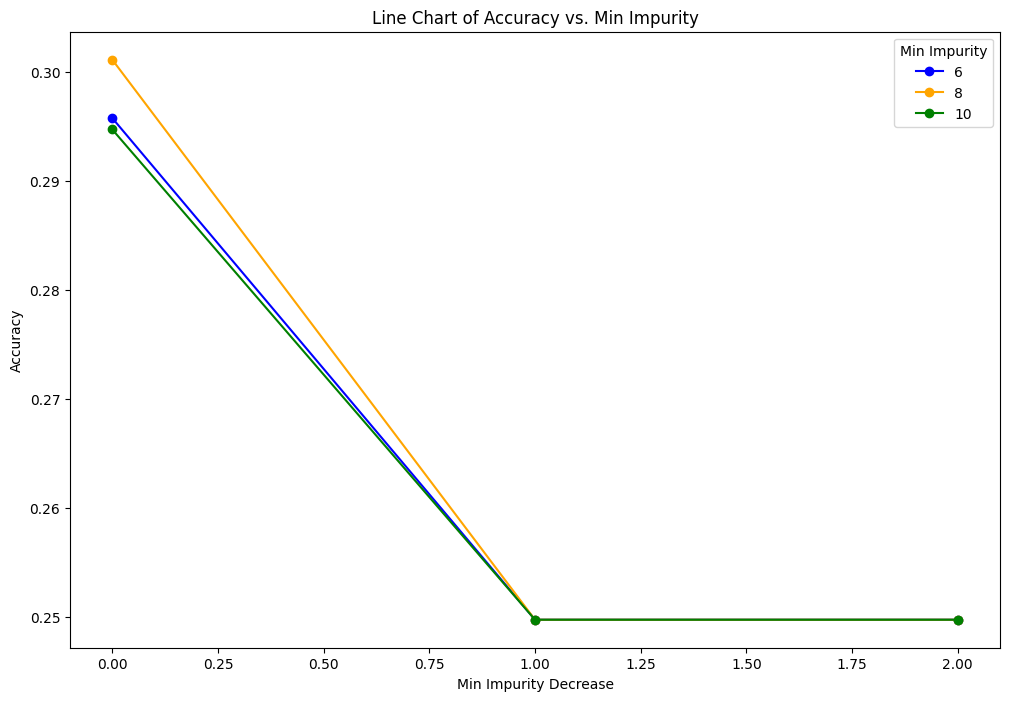

In [ ]:
max_depth1  = results_df2[results_df2['Max Depth'] == 6]
max_depth2  = results_df2[results_df2['Max Depth'] == 8]
max_depth3  = results_df2[results_df2['Max Depth'] == 10]

plt.figure(figsize=(12, 8))

plt.plot(max_depth1['Min Impurity'], max_depth1['Accuracy'], label= 6, marker='o', linestyle='-', color='blue')
plt.plot(max_depth2['Min Impurity'], max_depth2['Accuracy'], label=8, marker='o', linestyle='-', color='orange')
plt.plot(max_depth3['Min Impurity'], max_depth3['Accuracy'], label=10, marker='o', linestyle='-', color='green')

plt.title('Line Chart of Accuracy vs. Min Impurity')
plt.xlabel('Min Impurity Decrease')
plt.ylabel('Accuracy')
plt.legend(title='Min Impurity')
plt.show()

In [ ]:
param_grid3 = {
    'criterion': ["x"],
    'max_depth': [4,8,12,16,20],
    'min_samples_leaf': [0.5, 2, 3.5, 6, 7.5],
}

grid_model3 = DecisionTreeClassifier(random_state=42)
# Create the grid search object
grid_search3 = GridSearchCV(estimator=grid_model3, param_grid=param_grid3, scoring='accuracy', cv=5)
# Fit the grid search to the data
grid_search3.fit(X_train_flatten, y_train)

In [ ]:
# Get the best hyperparameters from the grid search
best_params3 = grid_search3.best_params_
print("Best Hyperparameters:", best_params3)

In [ ]:
# Use the best model to make predictions on the validation set
best_grid_model3 = grid_search3.best_estimator_
y_pred_val3 = best_grid_model3.predict(X_val_flatten)
y_pred_val3

array([2, 2, 6, ..., 4, 3, 0])

In [ ]:
cm3 = confusion_matrix(y_pred_val3,y_val)
print(cm3)
accuracy_score(y_val, y_pred_val3)

[[161  10  92 169 130 144  72]
 [ 12  25   9  14   8  17   7]
 [120   7 195 173 130 132  78]
 [194  19 174 579 215 210  93]
 [139  13 136 172 260 154  73]
 [160  14 136 193 190 227  65]
 [ 70   6  85  69  64  69 259]]


0.2970572871321609

Manuel Search

Manuel 1)

In [ ]:
classifier1 = DecisionTreeClassifier(criterion = "gini", random_state=42)
classifier1.fit(X_train_flatten,y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_1 = classifier1.predict(X_val_flatten)
cm = confusion_matrix(y_val, y_pred_1)
print(cm)
accuracy_score(y_val, y_pred_1)

Manuel 2)

In [ ]:
classifier2 = DecisionTreeClassifier(criterion = "entropy", random_state=42)
classifier2.fit(X_train_flatten,y_train)

In [ ]:
y_pred_2 = classifier2.predict(X_val_flatten)
cm = confusion_matrix(y_val, y_pred_2)
print(cm)
accuracy_score(y_val, y_pred_2)

Manuel 3)

In [ ]:
classifier3 = DecisionTreeClassifier(criterion = "entropy", max_depth = 2, random_state=42)
classifier3.fit(X_train_flatten,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

In [ ]:
y_pred_3 = classifier3.predict(X_val_flatten)
cm = confusion_matrix(y_val, y_pred_3)
print(cm)
accuracy_score(y_val, y_pred_3)

[[   0    0    0  627    0   64   87]
 [   0    0    0   85    0    1    6]
 [   0    0    0  670    0   57  108]
 [   0    0    0 1332    0   66   86]
 [   0    0    0  831    0   43   73]
 [   0    0    0  796    0   79  110]
 [   0    0    0  396    0   30  196]]


0.27981890997736375

Manuel 4)

In [ ]:
classifier4 = DecisionTreeClassifier(criterion = "entropy", random_state=42)
classifier4.fit(X_train_flatten,y_train)

In [ ]:
y_pred_4 = classifier4.predict(X_val_flatten)
cm = confusion_matrix(y_val, y_pred_4)
print(cm)
accuracy_score(y_val, y_pred_4)

In [ ]:
results= []
for i in range(100):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = i)
    classifier.fit(X_train_flat,y_train_1)
    y_pred_1 = classifier.predict(X_test_flat)
    y_pred_1 = np.argmax(y_pred_1, axis=1)
    cm = confusion_matrix(y_test_1, y_pred_1)
    accur_sc = accuracy_score(y_test_1, y_pred_1)
    results.append(accur_sc)
print(results)

#Model

Final Model's Graph

[Text(0.5, 0.8333333333333334, 'x[743] <= 151.5\nentropy = 2.611\nsamples = 22972\nvalue = [3217, 344, 3262, 5737, 4018, 3845, 2549]'),
 Text(0.25, 0.5, 'x[1848] <= 47.5\nentropy = 2.537\nsamples = 10261\nvalue = [1545, 135, 1369, 2509, 1932, 2216, 555]'),
 Text(0.125, 0.16666666666666666, 'entropy = 2.59\nsamples = 1384\nvalue = [274, 12, 184, 207, 186, 339, 182]'),
 Text(0.375, 0.16666666666666666, 'entropy = 2.507\nsamples = 8877\nvalue = [1271, 123, 1185, 2302, 1746, 1877, 373]'),
 Text(0.75, 0.5, 'x[1896] <= 94.5\nentropy = 2.621\nsamples = 12711\nvalue = [1672, 209, 1893, 3228, 2086, 1629, 1994]'),
 Text(0.625, 0.16666666666666666, 'entropy = 2.564\nsamples = 2565\nvalue = [365, 31, 449, 328, 291, 351, 750]'),
 Text(0.875, 0.16666666666666666, 'entropy = 2.59\nsamples = 10146\nvalue = [1307, 178, 1444, 2900, 1795, 1278, 1244]')]

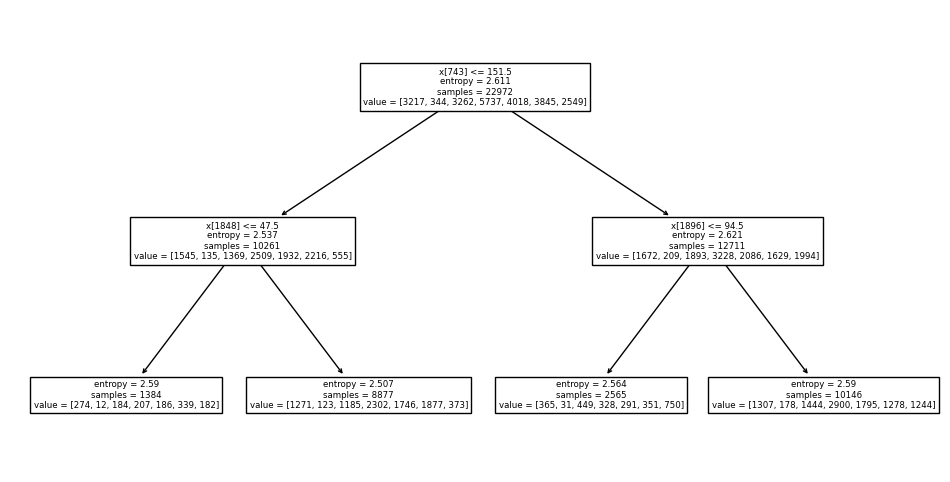

In [ ]:
fig = plt.figure(figsize=(12,6))
pl = tree.plot_tree(classifier3)
pl

In [ ]:
f, axes = plt.subplots(1,2,figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
          annot = True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred),
          annot = True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

#Prediction and Evaluation

Predict

In [ ]:
y_pred = classifier.predict(X_test)
#y_pred = np.argmax(y_pred, axis=1)
#y_test_n = np.argmax(y_test, axis=1)

In [ ]:
y_pred

Confusion Matrix


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

Try other random states values

In [ ]:
results= []
for i in range(100):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = i)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    accur_sc = accuracy_score(y_test, y_pred)
    results.append(accur_sc)
print(results)

In [ ]:
print(max(results))

In [ ]:
print(sum(results)/len(results))